In [1]:
import pandas as pd
import numpy as np
import re
import string
import time
from datetime import datetime
from datetime import date
import os
import random

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries

from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier


from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

# Save model
import pickle
import joblib

## Run settings

chosen_feature_predicting : Gender, rating_count , rating_value , review_count_critic , review_count_user , metascore
<br>chosen_bin_method : quartiles , bin_cut , Bin_AsPaper
<br>chosen_success_class : movie_rating , director_rating
<br>chosen_dataset_balance : unbalanced , balanced
<br>chosen_kernel_type : linear , poly , rbf, LinearSVC

In [48]:
# chosen_feature_predicting = 'Gender'
gender_as_an_input = 'Yes'
chosen_feature_predicting = 'average_rating_count'
chosen_bin_method = 'quartiles'
chosen_success_class = 'director_class'
chosen_dataset_ratio = 'unbalanced'
chosen_kernel_type = 'LinearSVC'
chosen_gamma_type = 'auto'
chosen_scaling_method = 'MinMaxScaler'

In [3]:
running = 'directors'
# fileName = '1_Director_Data_Mar-21-2020'
fileName = '2_Director_Data_Enhanced_May-10-2020'
# fileName = '3_USA_Director_Specific_dataset_May-15-2020'

In [4]:
# dynamic path location

dataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\'+ fileName +'.csv')

# storedDF = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\StoreDF_Mar-25-2020.csv'
# storeModelLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\Classification Models\\SVM'

saveFileToPath = "C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\"

director_data = pd.read_csv(dataFileLocation)
director_data.info()
# storeDF = pd.read_csv(storedDF)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 64 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   director_ids                                1651 non-null   object 
 1   director_name                               1651 non-null   object 
 2   average_rating_value                        1651 non-null   float64
 3   average_rating_count                        1651 non-null   float64
 4   movies_produced                             1651 non-null   int64  
 5   career_Length                               1651 non-null   int64  
 6   CareerStartYear                             1651 non-null   int64  
 7   Gender                                      1651 non-null   object 
 8   birthYear                                   1651 non-null   int64  
 9   median_inter_event_time                     1651 non-null   float64
 10  average_inte

In [5]:
# storeDF_col_names =  ['run_model','features_selected', 'record_count', 'male_count','female_count','predicting','Order_ABS','Order_Pos_Neg',
#               'TN','FP','FN','TP','total_time']
# # storeDF  = pd.DataFrame(columns = storeDF_col_names)

In [6]:
def undersampling_balanced_gender(df,balance_feature = 'Gender', column_tobe_unique = 'director_ids'):
    
    # Shuffle the Dataset.
    shuffled_data = df.sample(frac=1,random_state=42)
    print('Unbalanced dataframe shape after undersampling :',shuffled_data.shape)

    # First remove all duplicates director_ids to have only unique columns
    unique_column_df = shuffled_data.drop_duplicates(subset = column_tobe_unique, keep='first', inplace=False)
    unique_column_df.shape
    
    # An empty balanced data frame with only the unique columns
    bal_total_unique_list_df = pd.DataFrame()
    
    # Add balanced values from all the possible classes    
    for i in unique_column_df[balance_feature].value_counts().index:
        bal_total_unique_list_df = bal_total_unique_list_df.append(unique_column_df[(unique_column_df[balance_feature]==i)]
                                                   .sample(
                                                       n= unique_column_df[balance_feature].value_counts().values.min(),
                                                       random_state = 42,
                                                       replace = False)
                                                  )
    # list of unique IDs
    total_list_unique_IDs = bal_total_unique_list_df[column_tobe_unique].to_list()
    
    balanced_data = shuffled_data[shuffled_data[column_tobe_unique].isin(total_list_unique_IDs)] 
    
    print('Balanced dataframe shape after undersampling :',balanced_data.shape)
    return balanced_data

# Functions : Bin Cuts , Quartile Bins and bins as in paper

## Bin Cuts

In [7]:
def bincuts(df,class_feature = 'rating_value'):
    
    # Bin cuts into 4 buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.cut(df[class_feature].to_list(), bins = 4 ,labels=bin_quartiles)

    # Print the quartile range for visuals
    print(cutIntoQuartiles.categories)

    # Add the data to the dataframe
    df[chosen_success_class] = cutIntoQuartiles
    print('The shape of our Movies dataset is:', df.shape)
    df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our Movies dataset is:', df.shape)

## Quartile Bins

In [8]:
def quartile_bin(df,class_feature='rating_value'):
    # Quartile cut into 4 different buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.qcut(df[class_feature].to_list(), q=4,labels=bin_quartiles)
    
    print(cutIntoQuartiles.categories)
    
    df[chosen_success_class] = cutIntoQuartiles
    df[chosen_success_class] = df[chosen_success_class].astype(object)
    print('The shape of our dataset before dropping the class feature is:', df.shape)
    df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our dataset after dropping the class feature  is:', df.shape)
    return df

## Paper Implementation of bins

In [9]:
def success_measure(score):
    
    if score > 0 and score <= 2.4:
        return 'poor'
#     elif score > 2.4 and score <= 5.0:a
        return 'average'
    elif score > 5.0 and score <= 7.4:
        return 'good'
    elif score > 7.4 and score <=10.0:
        return 'excellent'
    else:
        return 'Error_Score'

# Function - To choose which Success measure to choose and what binning technique

In [10]:
def choose_success_measure(df, bin_method = 'Quartiles', feature = 'rating_value'):
    
    # Stats of the feature
    print('\nDescribing the feature : \n')
    print(df[feature].describe())
    

    
    if (bin_method == 'quartiles'):
        # Quartie bin cuts
        df = quartile_bin(df,feature)
            
    elif(bin_method == 'bin_cut'):
        # Bin cuts
        df = bincuts(df,'rating_value')
        
    elif(bin_method == 'Bin_AsPaper'):
        df[chosen_success_class] = df[feature].apply(success_measure).astype('category')
        
    print('\nThe shape of our dataset is:', df.shape)
    
    print('\nValue Count of the bucketed class is : \n')
    print(df[chosen_success_class].value_counts())

### Balance Gender

In [11]:
balanced_director_data = undersampling_balanced_gender(director_data)

Unbalanced dataframe shape after undersampling : (1651, 64)
Balanced dataframe shape after undersampling : (546, 64)


In [12]:
balanced_director_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 926 to 1638
Data columns (total 64 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   director_ids                                546 non-null    object 
 1   director_name                               546 non-null    object 
 2   average_rating_value                        546 non-null    float64
 3   average_rating_count                        546 non-null    float64
 4   movies_produced                             546 non-null    int64  
 5   career_Length                               546 non-null    int64  
 6   CareerStartYear                             546 non-null    int64  
 7   Gender                                      546 non-null    object 
 8   birthYear                                   546 non-null    int64  
 9   median_inter_event_time                     546 non-null    float64
 10  average_int

### Choosing dataset for the analysis

In [13]:
chosen_dataframe = ''
if(chosen_dataset_ratio == 'unbalanced'):
    chosen_dataframe = director_data
elif(chosen_dataset_ratio == 'balanced'):
    chosen_dataframe = balanced_director_data

### Remove Features from dataset which are not required

In [14]:
object_features_to_remove = chosen_dataframe.select_dtypes(include = 'object').columns.values.tolist()
object_features_to_remove.remove('Gender')
object_features_to_remove

['director_ids', 'director_name']

## Run the feature based on the bin cut and success feature

In [15]:
chosen_feature_predicting

'average_rating_count'

In [16]:
cutIntoQuartiles = pd.qcut(chosen_dataframe[chosen_feature_predicting].to_list(), q=4)
print("Quantiles bin range")
for i,num in enumerate(cutIntoQuartiles.categories):
    print("Quantile {0} : {1} ".format(i,num))

Quantiles bin range
Quantile 0 : (28.999, 7575.0] 
Quantile 1 : (7575.0, 30158.0] 
Quantile 2 : (30158.0, 88704.0] 
Quantile 3 : (88704.0, 933609.67] 


In [17]:
choose_success_measure(chosen_dataframe , bin_method = chosen_bin_method , feature = chosen_feature_predicting)


Describing the feature : 

count      1651.000000
mean      67189.358649
std       98676.655825
min          29.000000
25%        7575.000000
50%       30158.000000
75%       88704.000000
max      933609.670000
Name: average_rating_count, dtype: float64
Index(['terrible', 'poor', 'average', 'excellent'], dtype='object')
The shape of our dataset before dropping the class feature is: (1651, 65)
The shape of our dataset after dropping the class feature  is: (1651, 64)

The shape of our dataset is: (1651, 64)

Value Count of the bucketed class is : 

terrible     414
excellent    413
poor         412
average      412
Name: director_class, dtype: int64


### Chosen Director Dataset

In [18]:
print('The shape of our chosen director dataset before removing object type features:', chosen_dataframe.shape)
# movies_data = movies_data[movies_data.columns.difference(object_features_to_remove)]
chosen_dataframe = chosen_dataframe.drop(columns= object_features_to_remove)
print('The shape of our chosen director dataset after dropping object type features:', chosen_dataframe.shape)

The shape of our chosen director dataset before removing object type features: (1651, 64)
The shape of our chosen director dataset after dropping object type features: (1651, 62)


In [19]:
chosen_dataframe[chosen_success_class].value_counts()

terrible     414
excellent    413
poor         412
average      412
Name: director_class, dtype: int64

### Generic Functions

In [20]:
# Helper method for save_to_file

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [21]:
# Function: Save Dataframe to CSV

def save_to_file(dataFrame, folderPath):
    today = date.today()
    todayDate = today.strftime("%b-%d-%Y")
#     dataFrame.to_csv(folderPath+ '\\' + get_df_name(dataFrame) + '_' + todayDate  + '.csv',index=False, encoding="utf8" )
    dataFrame.to_csv(folderPath+ '\\' + get_df_name(dataFrame) + '_' + todayDate  + '.csv',index=False, encoding="utf-8-sig" )

### One hot encoding for Gender

In [22]:
def one_hot_encode_gender(df,one_hot_feature = 'Gender'):
    print('Before one hot encoding , Shape ;', df.shape)
    # one hot encoding of Gender
    df = pd.concat([df, pd.get_dummies(df[one_hot_feature],prefix= one_hot_feature,dtype = int)],axis=1)
    df.drop([one_hot_feature],axis=1, inplace=True)
    print('After one hot encoding , Shape ;', df.shape)
    df.head(2)
    return df

In [23]:
chosen_dataframe = one_hot_encode_gender(chosen_dataframe)

Before one hot encoding , Shape ; (1651, 62)
After one hot encoding , Shape ; (1651, 63)


In [24]:
def reverse_one_hot_encoding(df):
    reverse_one_hot_Gender = df.loc[:, df.columns.str.startswith('Gender')].idxmax(axis = 'columns')
    df['Gender'] = reverse_one_hot_Gender

    # Replace Gender_Male with Male and Gender_Female with Female
    df['Gender'] = df['Gender'].str.replace('Gender_male','Male')
    df['Gender'] = df['Gender'].str.replace('Gender_Female','Female')
    # Drop the one hot encoded value
    df.drop(['Gender_Female','Gender_male'],axis=1, inplace=True)
    return df

## Decide if Gender is an input feature or not

In [25]:
gender_as_an_input

'Yes'

In [26]:
if(gender_as_an_input == 'Yes'):
    print("Gender is an input feature for this run! No dropping!")
    print('The shape of our Chosen dataset after dropping Gender features:', chosen_dataframe.shape)
else:
    chosen_dataframe.drop(columns = ['Gender_Male','Gender_Female'],inplace = True)
    print("Gender features removed as it is not an input feature for this run!  ")
    print('The shape of our Chosen dataset after dropping Gender features:', chosen_dataframe.shape)

Gender is an input feature for this run! No dropping!
The shape of our Chosen dataset after dropping Gender features: (1651, 63)


In [27]:
chosen_dataset_ratio

'unbalanced'

In [28]:
chosen_dataframe[chosen_success_class].value_counts()

terrible     414
excellent    413
poor         412
average      412
Name: director_class, dtype: int64

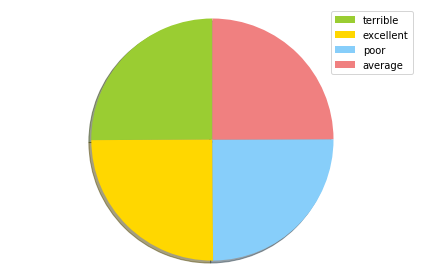

In [29]:
# Visualizing Outcome Distribution 
temp = chosen_dataframe[chosen_success_class].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

#df.plot(kind='pie',labels='labels',values='values', title='Activity Ditribution',subplots= "True")

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [30]:
def divide_test_train_with_scaling_methods(df,predict= chosen_success_class,scalingMethod = "MinMaxScaler"):
    
    
    # Feature matrix and target variable
    X = df.drop(predict,axis = 'columns')
    y = df[predict]
    
    # Scaling
    if (scalingMethod == "MinMaxScaler"):
        print("The scaling method used is : ",scalingMethod)
        scaler = MinMaxScaler()
        new_X = scaler.fit_transform(X)
        # X_test = scaler.transform(X_test)
        
    else:
        print("No Scaling Method used or incorrect input")
        new_X = X
    
    # Divide the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.20, random_state = 42 , stratify = y )
    
    return X_train, X_test, y_train, y_test

# Plot Confusion Matrix

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Function for Run Info :

In [32]:
def run_info(classifier):
    print('\n**Run Info - ' + classifier + '**')
    print('Dataset Shape :', chosen_dataframe.shape)
    print('Dataset ratio of classes is', chosen_dataset_ratio)
    print('Is gender an input feature :  ', gender_as_an_input)
    print('Predicting feature :', chosen_feature_predicting)
    print('Bin Method :', chosen_bin_method)
    print('Scaling Method :', chosen_scaling_method)
    print('With Gender?? :', gender_as_an_input)
    print('****************\n')
    return

### Function to print customized classification report

In [33]:
def customized_classification_report(y_true,y_pred, AUCROC ):
    cols_to_use_classification_report = ['terrible','poor','average','excellent','accuracy']
    reportGBClassification = classification_report(y_true,
                                                   y_pred,
                                                   labels = cols_to_use_classification_report[:-1],
                                                   output_dict=True)
    
    reportDF = pd.DataFrame(reportGBClassification, columns = cols_to_use_classification_report)[0:3]
    reportDF[['terrible','poor','average','excellent']] = reportDF[['terrible','poor','average','excellent']].round(2)
    
    accuracyRow = reportDF['accuracy'].unique().tolist()
    
    reportDF.drop(columns='accuracy',inplace= True)

    reportDF.loc[len(reportDF)] = 4 * accuracyRow
    reportDF.loc[len(reportDF)] = 4 * [round(AUCROC,2)]

    reportDF = reportDF.rename(index = {3:'accuracy',4:'AUC ROC'})
    return reportDF

# SVM Classifier

In [41]:
def train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType='linear',gamma_parameter='auto'):
    
    start = time.time()
    print("Started Reading files at :" + str(datetime.utcfromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')))
    
    labelMovieClass = ['terrible','poor','average','excellent']
#     labelMovieClass = [1,2,3,4]
    
    # SVM Classifier parameters
    
    if(kernelType == 'linear'):
        svclassifier = SVC(kernel = kernelType,
                           gamma = gamma_parameter,
                           probability=True
                          )
        clf = svclassifier
        
    elif(kernelType == 'LinearSVC'):
        svclassifier = LinearSVC(random_state = 42,
                                 tol=1e-5,
                                 multi_class = 'ovr'
                                )
        # Using Calibrated Classifier cross validation and One VsRest classifier
        clf0 = CalibratedClassifierCV(svclassifier, cv=10)
        clf = OneVsRestClassifier(clf0, n_jobs = 10)
        
    elif(kernelType == 'poly'):
        svclassifier = SVC(kernel=kernelType,
                           gamma = gamma_parameter,
#                            probability=True,
                           degree=8
                          )
    elif(kernelType == 'rbf'):
        svclassifier = SVC(kernel=kernelType,
#                            probability=True,
                    )
    elif(kernelType == 'sigmoid'):
        svclassifier = SVC(kernel=kernelType,
#                            probability=True,
                )
    
#     #Using Bagging classifier with SVC
#     clf = BaggingClassifier(base_estimator = svclassifier,
#                                      n_estimators=10, 
#                                      random_state= 42)    
    
#     #Using One Vs Rest classifier with SVC    
#     clf = OneVsRestClassifier(svclassifier, n_jobs = 10)
    
      
    # SVM Classifier Fit
    clf.fit(X_train, y_train)

    # Predict classes
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)

    
#     cnf_matrix = confusion_matrix(y_test, y_pred,labels= labelMovieClass )
    cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)
    
    classifier_name = svclassifier.__class__.__name__
    train_size = int(round((len(X_train) / len(chosen_dataframe)),1) * 100)
    test_size = int(round((len(X_test) / len(chosen_dataframe)),1) * 100)
    
    # Print run info
    run_info(classifier_name)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes= labelMovieClass,
                      title='Confusion matrix, without normalization')
    
       
    svm_train_score = clf.score(X_train, y_train)
    print("\nTraining Score of {0} on {2} % data : {1} ".format(classifier_name,round(svm_train_score,3),train_size))
    
    svm_test_score = clf.score(X_test, y_test)
    print("Testing Score of {0} on {2} % data : {1} ".format(classifier_name,round(svm_test_score,3),test_size))

    # Performance metrics
    macro_ovo_roc_auc = roc_auc_score(y_test, y_prob,average= "macro" , multi_class = 'ovo')
    print( "\nArea Under the Curve - ROC (OVO , Macro) : ",round(macro_ovo_roc_auc,3))
    print( "Matthews_corrcoef : ", round(metrics.matthews_corrcoef(y_test, y_pred),3))
    

    print("\nClassification Report\n")
    print(classification_report(y_test, y_pred, labels = labelMovieClass ))
    
    # Stop timer
    end = time.time()
    print("\nStopped Reading files at :" + str(datetime.utcfromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')))
    total_time = str(round((end - start)/60,2))
    print("Total time taken in seconds: " + str((end - start)))
    
    return svclassifier,y_test,y_pred,macro_ovo_roc_auc

## Running Director Dataset - with model features

### Small sample for test

In [ ]:
# for i in range(2):
#     print('Round',i+4)
#     NOR= 10000 * (i+4)
#     print('Number of Rows',NOR)
#     testSample =  chosen_dataframe.sample(n= NOR , random_state = 42 , replace = False)
#     # Divide the data into training and test
#     X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(testSample,scalingMethod= chosen_scaling_method)
#     svclassifier,total_time = train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType= chosen_kernel_type ,gamma_parameter= chosen_gamma_type)
#     print('Total Time in minutes: ', total_time )

In [ ]:
# # Comment this line if you want to use the originally chosen dataframe

# testSample =  chosen_dataframe.sample(n= 10000 , random_state = 42 , replace = False)
# # chosen_dataframe = testSample

In [42]:
chosen_dataframe[chosen_dataframe['birthYear'] == 6]

,average_rating_value,movies_produced,career_Length,CareerStartYear,birthYear,median_inter_event_time,average_inter_event_time,total_review_count_user,total_review_count_critic,total_metascore,...,director_profession_tertiary,director_known_titles_count,director_known_titles_average_rating_value,average_movie_per_year,num_countries_screened,num_genres_directed,num_languages_released,director_class,Gender_Female,Gender_Male


In [43]:
# Divide the data into training and test

X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(chosen_dataframe,scalingMethod= chosen_scaling_method)

The scaling method used is :  MinMaxScaler


In [44]:
X_train.shape , y_train.shape

((1320, 62), (1320,))

In [45]:
X_test.shape , y_test.shape

((331, 62), (331,))

For Dataset 1<br>
50 seconds for 10000 records<br>
200 seconds for 20000 records

Started Reading files at :2020-05-16 09:57:06

**Run Info - LinearSVC**
Dataset Shape : (1651, 63)
Dataset ratio of classes is unbalanced
Is gender an input feature :   Yes
Predicting feature : average_rating_count
Bin Method : quartiles
Scaling Method : MinMaxScaler
With Gender?? : Yes
****************

Confusion matrix, without normalization
[[38 10 22 13]
 [ 9 66  4  4]
 [19  2 28 33]
 [ 4  1 19 59]]

Training Score of LinearSVC on 80 % data : 0.655 
Testing Score of LinearSVC on 20 % data : 0.577 

Area Under the Curve - ROC (OVO , Macro) :  0.834
Matthews_corrcoef :  0.439

Classification Report

              precision    recall  f1-score   support

    terrible       0.54      0.71      0.61        83
        poor       0.38      0.34      0.36        82
     average       0.54      0.46      0.50        83
   excellent       0.84      0.80      0.81        83

    accuracy                           0.58       331
   macro avg       0.58      0.58      0.57       331
weighted av

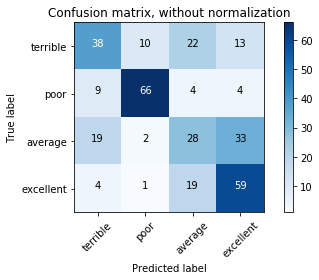

In [49]:
svclassifier,y_true , y_pred, AUCROC  = train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType= chosen_kernel_type ,gamma_parameter= chosen_gamma_type)

In [47]:
SVM_reportDF = customized_classification_report(y_true,y_pred,AUCROC)
SVM_reportDF

,terrible,poor,average,excellent
precision,0.520000,0.380000,0.520000,0.900000
recall,0.670000,0.340000,0.570000,0.650000
f1-score,0.590000,0.360000,0.540000,0.760000
accuracy,0.558912,0.558912,0.558912,0.558912
AUC ROC,0.810000,0.810000,0.810000,0.810000


In [ ]:
break

# SHAP

In [ ]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier

svm = sklearn.svm.SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, shap.kmeans(X_train,10), link="logit")
shap_values = explainer.shap_values(X_test)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

In [52]:
import shap


In [64]:
def train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType='linear',gamma_parameter='auto'):
    
    start = time.time()
    print("Started Reading files at :" + str(datetime.utcfromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')))
    
    labelMovieClass = ['terrible','poor','average','excellent']
#     labelMovieClass = [1,2,3,4]
    
    # SVM Classifier parameters
    
    if(kernelType == 'linear'):
        svclassifier = SVC(kernel = kernelType,
                           gamma = gamma_parameter,
                           probability=True
                          )
        
    elif(kernelType == 'LinearSVC'):
        svclassifier = LinearSVC(random_state = 42,
                                 tol=1e-5,
                                 multi_class = 'ovr'
                                )
        # Using Calibrated Classifier cross validation and One VsRest classifier
        clf0 = CalibratedClassifierCV(svclassifier, cv=10)
        clf = OneVsRestClassifier(clf0, n_jobs = 10)
        
    elif(kernelType == 'poly'):
        svclassifier = SVC(kernel=kernelType,
                           gamma = gamma_parameter,
#                            probability=True,
                           degree=8
                          )
    elif(kernelType == 'rbf'):
        svclassifier = SVC(kernel=kernelType,
#                            probability=True,
                    )
    elif(kernelType == 'sigmoid'):
        svclassifier = SVC(kernel=kernelType,
#                            probability=True,
                )
    
#     #Using Bagging classifier with SVC
#     clf = BaggingClassifier(base_estimator = svclassifier,
#                                      n_estimators=10, 
#                                      random_state= 42)    
    
#     #Using One Vs Rest classifier with SVC    
#     clf = OneVsRestClassifier(svclassifier, n_jobs = 10)
    
     



    
    # SVM Classifier Fit
    clf.fit(X_train, y_train)

    # Predict classes
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
  
    
#     cnf_matrix = confusion_matrix(y_test, y_pred,labels= labelMovieClass )
    cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)
    
    classifier_name = svclassifier.__class__.__name__
    train_size = int(round((len(X_train) / len(chosen_dataframe)),1) * 100)
    test_size = int(round((len(X_test) / len(chosen_dataframe)),1) * 100)
    
    # Print run info
    run_info(classifier_name)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes= labelMovieClass,
                      title='Confusion matrix, without normalization')
    
       
    svm_train_score = clf.score(X_train, y_train)
    print("\nTraining Score of {0} on {2} % data : {1} ".format(classifier_name,round(svm_train_score,3),train_size))
    
    svm_test_score = clf.score(X_test, y_test)
    print("Testing Score of {0} on {2} % data : {1} ".format(classifier_name,round(svm_test_score,3),test_size))

    # Performance metrics
    macro_ovo_roc_auc = roc_auc_score(y_test, y_prob,average= "macro" , multi_class = 'ovo')
    print( "\nArea Under the Curve - ROC (OVO , Macro) : ",round(macro_ovo_roc_auc,3))
    print( "Matthews_corrcoef : ", round(metrics.matthews_corrcoef(y_test, y_pred),3))
    

    print("\nClassification Report\n")
    print(classification_report(y_test, y_pred, labels = labelMovieClass ))
    
    # Stop timer
    end = time.time()
    print("\nStopped Reading files at :" + str(datetime.utcfromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')))
    total_time = str(round((end - start)/60,2))
    print("Total time taken in seconds: " + str((end - start)))
    
    return clf, svclassifier,y_test,y_pred,macro_ovo_roc_auc

Started Reading files at :2020-05-16 10:13:22

**Run Info - LinearSVC**
Dataset Shape : (1651, 63)
Dataset ratio of classes is unbalanced
Is gender an input feature :   Yes
Predicting feature : average_rating_count
Bin Method : quartiles
Scaling Method : MinMaxScaler
With Gender?? : Yes
****************

Confusion matrix, without normalization
[[38 10 22 13]
 [ 9 66  4  4]
 [19  2 28 33]
 [ 4  1 19 59]]

Training Score of LinearSVC on 80 % data : 0.655 
Testing Score of LinearSVC on 20 % data : 0.577 

Area Under the Curve - ROC (OVO , Macro) :  0.834
Matthews_corrcoef :  0.439

Classification Report

              precision    recall  f1-score   support

    terrible       0.54      0.71      0.61        83
        poor       0.38      0.34      0.36        82
     average       0.54      0.46      0.50        83
   excellent       0.84      0.80      0.81        83

    accuracy                           0.58       331
   macro avg       0.58      0.58      0.57       331
weighted av

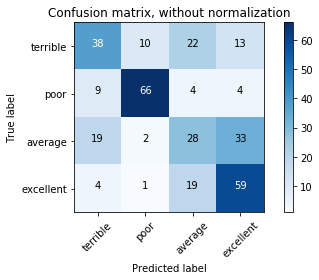

In [65]:
clf , svclassifier,y_true , y_pred, AUCROC  = train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType= chosen_kernel_type ,gamma_parameter= chosen_gamma_type)

In [66]:
# print the JS visualization code to the notebook
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(clf.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=5)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test[0,:], link="logit")

Using 1320 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.485e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.485e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.423e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.423e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.542e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.708e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.708e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.708e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.777e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.484e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.484e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.748e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.954e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.954e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.954e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.336e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.118e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.206e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.294e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.470e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.470e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.470e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.348e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.095e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.095e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.738e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.444e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.444e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.482e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.283e-01, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.220e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.490e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.619e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.619e-03, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.491e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.246e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.246e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.174e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next vers

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.861e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.714e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.147e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.555e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.490e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.756e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.756e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.001e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.797e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.007e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.907e-04, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.134e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.567e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.567e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.534e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.764e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.716e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.882e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.882e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.760e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.798e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.798e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.541e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.770e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.770e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.770e-02, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.362e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.511e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.810e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.810e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.780e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.780e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.901e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.901e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.502e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.268e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.268e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.418e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.962e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.294e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.004e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.004e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.002e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.002e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.153e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.077e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.077e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.796e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.996e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.715e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.498e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.498e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.062e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.310e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.295e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.295e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.664e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.332e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.332e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.332e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.386e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.193e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.802e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.959e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.502e-04, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.751e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.142e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.571e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.571e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.917e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.064e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.064e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.648e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.769e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.843e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.893e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.255e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.178e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.178e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.543e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.094e-02, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.140e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.570e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.570e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.570e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.728e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.262e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.262e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.053e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.513e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.269e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.269e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.849e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.533e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.667e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.667e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.115e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.027e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.513e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.513e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.308e-02, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.978e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.997e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.964e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.373e-03, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.421e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.223e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.112e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.017e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.509e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.035e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.507e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.619e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.549e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.549e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.475e-01, with an active set of 2 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.744e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.872e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.872e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps paramete

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.163e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.081e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.081e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.809e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.801e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.005e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.005e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.964e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.594e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.594e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.216e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.216e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next vers

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.508e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.754e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.754e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.081e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.269e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.634e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.242e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.793e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.397e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.550e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.675e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.337e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.036e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.913e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.388e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.388e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.694e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.923e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.962e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.962e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.837e-03, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.057e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.057e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.057e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.528e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.692e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.447e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.447e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.244e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.062e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.308e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.308e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.308e-04, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.290e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.290e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.290e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.984e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.256e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.628e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.625e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.789e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.025e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.359e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.246e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.623e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.536e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.798e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.668e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.225e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.435e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.622e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.622e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.152e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.931e-01, with an active set of 2 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.573e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.786e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.726e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.057e-03, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.259e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.630e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.630e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.069e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.069e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.035e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.035e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.032e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.016e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.016e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.239e-03, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.305e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.074e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.549e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.401e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next vers

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.837e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.101e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.590e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.663e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.759e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.880e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.880e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.135e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.053e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.266e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.266e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.266e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.391e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.696e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.377e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.118e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.118e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.686e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.296e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.148e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.148e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.148e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.559e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.279e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.279e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.204e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.261e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.261e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.944e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.847e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.554e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.277e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.349e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.592e-02, with an active set of 1 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.553e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.765e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.765e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.836e-02, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.233e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.233e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.060e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.060e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next vers

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.237e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.237e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.237e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.895e-02, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.031e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.031e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.016e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.016e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.688e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.844e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.117e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.851e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.425e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.425e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.364e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.743e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.871e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.871e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.520e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.601e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.601e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.601e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.749e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.749e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.749e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.749e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.629e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.815e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.815e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.848e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.387e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.693e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.693e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.655e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.689e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.345e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.345e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.345e-02, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.830e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.171e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.171e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.820e-03, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.279e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.396e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.396e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.396e-03, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.578e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.531e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.281e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.281e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.126e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.563e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.563e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.931e-04, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.181e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.181e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.166e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.156e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.515e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.575e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.529e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.529e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.705e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.352e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.352e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.561e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.281e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.281e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.651e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.563e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.806e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.281e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.150e-02, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.343e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.024e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.383e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.913e-02, with an active set of 2 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.714e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.629e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.629e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.198e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.099e-01, with an active set of 2 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.656e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.828e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.828e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.816e-03, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.379e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.379e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.221e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.610e-03, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.379e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.189e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.189e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.189e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.289e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.644e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.644e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.762e-04, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.625e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.625e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.417e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.280e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.409e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.409e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.123e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.248e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.240e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.240e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.268e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.193e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.097e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.324e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.075e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.373e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.373e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.662e-02, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.082e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.041e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.041e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.533e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.080e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.922e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.740e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.948e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.765e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.149e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.383e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps paramete

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.944e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.972e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.972e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.054e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.215e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.077e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.077e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.107e-03, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.295e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.295e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.073e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.474e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.343e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.171e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.688e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.471e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.736e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.736e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.324e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.616e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.808e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.146e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.404e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.468e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.202e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.071e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.064e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.968e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.528e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.528e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.706e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.353e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.991e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.496e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.390e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.390e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.782e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.912e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.912e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.088e-03, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.893e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.466e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.466e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.122e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.914e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.914e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.691e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.714e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.079e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.396e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.244e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.244e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.308e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.295e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.654e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.654e-03, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.011e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.011e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.746e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.051e-02, with an active set of 1 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.433e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.433e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.217e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.217e-02, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.695e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.035e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.463e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.732e-01, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.954e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.134e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.212e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.874e-02, with an active set of 2 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.445e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.859e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.223e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.440e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.220e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.220e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.368e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.731e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.779e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.779e-02, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.106e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.237e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.118e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.118e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.528e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.641e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.641e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.554e-03, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.370e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.234e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.234e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.707e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.618e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.809e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.809e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.809e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.819e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.496e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.083e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.083e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.437e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.219e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.360e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.378e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.890e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.250e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.125e-02, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.569e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.844e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.844e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.437e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.345e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.673e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.673e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.064e-04, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.466e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.233e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.233e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.233e-02, with an active set of 3 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.625e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.625e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.625e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.841e-02, with an active set of 4 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.017e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.017e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.447e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.447e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next vers

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.521e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.260e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.257e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.252e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.604e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.802e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.802e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.634e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.032e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.159e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.387e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.219e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.219e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.219e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.844e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.430e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.430e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.922e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.586e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.340e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.793e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.793e-02, with an active set of 3 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.458e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.434e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.257e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.245e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.301e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.150e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.150e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.798e-02, with an active set of 2 regressors, and 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.426e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.411e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.411e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.375e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.931e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.290e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.710e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.710e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.387e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.387e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.194e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.194e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.855e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.928e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.693e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.525e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.753e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.730e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.337e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.291e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.291e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.291e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.398e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.029e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.426e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.014e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.014e-01, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.989e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.989e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.495e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps paramete

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.333e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.333e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.166e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.166e-02, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.289e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.713e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.178e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.736e-03, with an active set of 4 regressors, and 

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.516e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.516e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.516e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.516e-02, with an active set of 4 regressors, and 

# Code ends here for SVM Testing

In [ ]:
# temp_director_only = movies_data.dropna(subset=model_features)
temp_director_only = movies_data
temp_director_only.info()

In [ ]:
def print_features_selected(df):
    print('[',end = '')
    for i,v in enumerate(df.columns.values):
        if(i==len(df.columns.values)-1):
            print("'" + str(v) +"']")
        else:
            print("'" + str(v) +"',")

In [ ]:
# # print_features_selected(temp_director_only)
# print_features_selected(maxEqualDF[model_features])

## Running Whole Director DF 

In [ ]:
y_test,y_pred,model_SVC = run_model_SVM(df = temp_director_only,
                                        predictingFeature= chosen_feature_predicting,
                                        kernelType= chosen_kernel_type,
                                        gamma= chosen_gamma_type
                                       )


In [ ]:
# y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,temp_director_only,storeDF,
#                                                                   model_features,'Gender','linear','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

In [ ]:
# #Save a copy of true and predicted for Manual intervention
# Actual = y_test.to_frame()
# Actual['predicter'] = y_pred
# save_to_file(Actual,saveFileToPath)

## Running Balanced max Equal DF 

In [ ]:
y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,maxEqualDF,storeDF,
                                                                  model_features,'Gender','linear','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

## Test Run sample DF

In [ ]:
y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,equalDF,storeDF,
                                                                  model_features,'Gender','poly','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

In [ ]:
save_to_file(storeDF,saveFileToPath)